### Objective

In this notebook, we aim to leverage the ML expertise of LLM to accelerate hyperparameter tuning

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import utilities
import os
from flaml import tune
from flaml import AutoML

import xgboost as xgb
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform
import scipy
import re

### 1. Data preparation

In [2]:
# import train data
train = pd.read_csv('dataset/train_AutoML_probe.csv')
train.rename(columns={'attack_category': 'attack'}, inplace=True)

# import test data
test = pd.read_csv('dataset/test_AutoML_probe.csv')
test.rename(columns={'attack_category': 'attack'}, inplace=True)

# Feature category
feature_names = defaultdict(list)
with open('dataset/feature_types.txt', 'r') as f:
    for line in f.readlines():
        feature, category = line.strip().strip('.').split(': ')
        feature_names[category].append(feature)

# Numerical features
num_feats = feature_names['continuous']
num_feats.remove('num_outbound_cmds')

# Binary features
binary_feats = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']

# Nominal features
nominal_feats = list(set(feature_names['discrete'])-set(binary_feats))

from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
train[nominal_feats] = enc.fit_transform(train[nominal_feats])
test[nominal_feats] = enc.transform(test[nominal_feats])

# Separate feature/label
X_train, y_train = train.iloc[:, :-1].to_numpy(), train.iloc[:, -1].to_numpy()
X_test, y_test = test.iloc[:, :-1].to_numpy(), test.iloc[:, -1].to_numpy()

### 2. Data profiling

In [3]:
report = utilities.data_report(train, num_feats, binary_feats, nominal_feats)

### 3. LLM chatbot

In [4]:
from langchain.chains import ConversationalRetrievalChain
from langchain.prompts import (
    ChatPromptTemplate, 
    MessagesPlaceholder, 
    SystemMessagePromptTemplate, 
    HumanMessagePromptTemplate
)
from langchain.chains import ConversationChain
from langchain.chat_models import ChatOpenAI, AzureChatOpenAI
from langchain.memory import ConversationBufferMemory

In [5]:
# Set up LLM
llm = ChatOpenAI(temperature=0.6)

memory = ConversationBufferMemory(return_messages=True)

In [21]:
last_run_best_score = []
all_time_best_score = []

#### 3.1 Suggest metrics

In [7]:
# Set up the system message
system_message = f"""
You are a senior data scientist tasked with guiding the use of an AutoML tool  
to discover the best XGBoost model configurations for a given binary classification dataset. 
Your role involves understanding the dataset characteristics, proposing suitable metrics, 
hyperparameters, and their search spaces, analyzing results, and iterating on configurations. 
"""

In [8]:
def suggest_metrics(report):
    
    prompt = f"""
    The classification problem under investigation is based on a network intrusion detection dataset. 
    This dataset contains DOS, Probe, R2L, and U2R attack types, which are all grouped under the 
    "attack" class (label: 1). Conversely, the "normal" class is represented by label 0. 
    Below are the dataset's characteristics:
    {report}.

    For this specific inquiry, you are tasked with recommending a suitable hyperparameter optimization 
    metric for training a XGBoost model. It is crucial that the model should accurately identify genuine 
    threats (attacks) without raising excessive false alarms on benign activities. They are equally important.
    Given the problem context and dataset characteristics, suggest only the name of one of the built-in 
    metrics: 
    - 'accuracy'
    - 'roc_auc' (ROCAUC score)
    - 'f1' (F1 score)
    - 'balanced_accuracy' (It is the macro-average of recall scores per class or, equivalently, raw 
    accuracy where each sample is weighted according to the inverse prevalence of its true class) 
    - 'average_precision'
    - 'precision'
    - 'recall'
    - 'neg_brier_score'
    
        
    Please first briefly explain your reasoning and then provide the recommended metric name. 
    Your recommendation should be enclosed between markers [BEGIN] and [END], with standalone string for 
    indicating the metric name.
    Do not provide other settings or configurations.
    """

    return prompt

In [9]:
def suggest_initial_search_space():
    
    prompt = f"""
    Given your understanding of XGBoost and general best practices in machine learning, suggest an 
    initial search space for hyperparameters. 

    Tunable hyperparameters include:
    - n_estimators (integer): Number of boosting rounds or trees to be trained.
    - max_depth (integer): Maximum tree depth for base learners.
    - min_child_weight (integer or float): Minimum sum of instance weight (hessian) needed in a leaf node. 
    - gamma (float): Minimum loss reduction required to make a further partition on a leaf node of the tree.
    - scale_pos_weight (float): Balancing of positive and negative weights.
    - learning_rate (float): Step size shrinkage used during each boosting round to prevent overfitting. 
    - subsample (float): Fraction of the training data sampled to train each tree. 
    - colsample_bylevel (float): Fraction of features that can be randomly sampled for building each level (or depth) of the tree.
    - colsample_bytree (float): Fraction of features that can be randomly sampled for building each tree. 
    - reg_alpha (float): L1 regularization term on weights. 
    - reg_lambda (float): L2 regularization term on weights. 

    The search space is defined as a dict with keys being hyperparameter names, and values 
    are the search space associated with the hyperparameter. For example:
        search_space = {{
            "learning_rate": loguniform(1e-4, 1e-3)
        }}

    Available types of domains include: 
    - scipy.stats.uniform(loc, scale), it samples values uniformly between loc and loc + scale.
    - scipy.stats.loguniform(a, b), it samples values between a and b in a logarithmic scale.
    - scipy.stats.randint(low, high), it samples integers uniformly between low (inclusive) and high (exclusive).
    - a list of possible discrete value, e.g., ["a", "b", "c"]

    Please first briefly explain your reasoning, then provide the configurations of the initial 
    search space. Enclose your suggested configurations between markers 
    [BEGIN] and [END], and assign your configuration to a variable named search_space.
    """

    return prompt

In [15]:
def suggest_refine_search_space(top_n, last_run_best_score, all_time_best_score):

    prompt = f"""
    Given your previously suggested search space, the obtained top configurations with their 
    test scores:
    {top_n}
    
    The best score from the last run was {last_run_best_score}, while the best score ever 
    achieved in all previous runs is {all_time_best_score}

    Remember, tunable hyperparameters are: n_estimators, max_depth, min_child_samples, gamma, 
    scale_pos_weight, learning_rate, subsample, colsample_bylevel, colsample_bytree, reg_alpha, 
    and reg_lambda.

    Given the insights from the search history, your expertise in ML, and the need to further 
    explore the search space, please suggest refinements for the search space in the next optimization round. 
    Consider both narrowing and expanding the search space for hyperparameters where appropriate.

    For each recommendation, please:
    1. Explicitly tie back to any general best practices or patterns you are aware of regarding XGBoost tuning
    2. Then, relate to the insights from the search history and explain how they align or deviate from these 
    practices or patterns.
    3. If suggesting an expansion of the search space, please provide a rationale for why a broader range could 
    be beneficial.


    Briefly summarize your reasoning for the refinements and then present the adjusted configurations. 
    Enclose your refined configurations between markers [BEGIN] and [END], and assign your 
    configuration to a variable named search_space.
    """
    
    return prompt

In [11]:
# Set up the prompt
prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(system_message),
    MessagesPlaceholder(variable_name="history"),
    HumanMessagePromptTemplate.from_template("""{input}""")
])

# Create conversation chain
conversation = ConversationChain(memory=memory, prompt=prompt, 
                                llm=llm, verbose=False)

In [12]:
# Suggest metrics
prompt = suggest_metrics(report)
response = conversation.predict(input=prompt)
print(response)

Given the problem context and the class imbalance in the dataset, we need a metric that balances both precision and recall. Precision is important because we want to minimize the number of false positives (benign activities that are incorrectly classified as attacks). Recall is also important because we want to minimize the number of false negatives (attacks that are incorrectly classified as benign activities).

The F1 score is a harmonic mean of precision and recall, and it balances these two metrics. Therefore, it is a suitable choice for this problem. 

The metric name is enclosed between the markers [BEGIN] and [END]:

[BEGIN]
'f1'
[END]


#### 3.2 Suggest initial search space

In [13]:
# Initial search space
prompt = suggest_initial_search_space()
response = conversation.predict(input=prompt)
print(response)

The aim of setting the initial hyperparameters search space is to explore a broad range of possible values. Here are some general guidelines for setting the hyperparameters:

- n_estimators: A high number of trees can lead to overfitting, and a low number to underfitting. Hence, a range from 100 to 1000 can be a good starting point.
- max_depth: Increasing this value will make the model more complex and more likely to overfit. A range of 3 to 10 is often good enough.
- min_child_weight: This parameter is used to control overfitting. The larger, the more conservative the algorithm will be. It can range from 1 to 20.
- gamma: The larger, the more conservative the algorithm will be. It can range from 0 to 5.
- scale_pos_weight: Given the class imbalance, this parameter should be greater than 1. We can try a range from 1 to 10.
- learning_rate: It is usually set between 0.01 to 0.2.
- subsample, colsample_bylevel, colsample_bytree: These parameters are for preventing overfitting. Values fr

In [14]:
%%time

search_space = {
    "n_estimators": scipy.stats.randint(100, 1000),
    "max_depth": scipy.stats.randint(3, 10),
    "min_child_weight": scipy.stats.randint(1, 20),
    "gamma": scipy.stats.uniform(0, 5),
    "scale_pos_weight": scipy.stats.uniform(1, 10),
    "learning_rate": scipy.stats.loguniform(0.01, 0.2),
    "subsample": scipy.stats.uniform(0.5, 0.5),
    "colsample_bylevel": scipy.stats.uniform(0.5, 0.5),
    "colsample_bytree": scipy.stats.uniform(0.5, 0.5),
    "reg_alpha": scipy.stats.loguniform(1e-5, 100),
    "reg_lambda": scipy.stats.loguniform(1e-5, 100),
}

clf = xgb.XGBClassifier(seed=42, objective='binary:logistic', 
                        eval_metric='logloss', n_jobs=-1, use_label_encoder=False)
# search = RandomizedSearchCV(clf, search_space, scoring='roc_auc', 
#                             n_iter=5, cv=5, verbose=1).fit(X_train, y_train)
search = HalvingRandomSearchCV(clf, search_space, scoring='f1', n_candidates=500,
                              cv=5, min_resources='exhaust', factor=3, verbose=1).fit(X_train, y_train)

n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 325
max_resources_: 78999
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 500
n_resources: 325
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
----------
iter: 1
n_candidates: 167
n_resources: 975
Fitting 5 folds for each of 167 candidates, totalling 835 fits
----------
iter: 2
n_candidates: 56
n_resources: 2925
Fitting 5 folds for each of 56 candidates, totalling 280 fits
----------
iter: 3
n_candidates: 19
n_resources: 8775
Fitting 5 folds for each of 19 candidates, totalling 95 fits
----------
iter: 4
n_candidates: 7
n_resources: 26325
Fitting 5 folds for each of 7 candidates, totalling 35 fits
CPU times: total: 3h 48min 48s
Wall time: 20min 35s


In [19]:
def extract_logs(results):

    # Assuming you have the logs in a DataFrame called df
    df = pd.DataFrame(search.cv_results_)

    # Number of top-performing configurations you want to extract
    top_n = 5

    # 1. Identify top-performing configurations using rank_test_score
    top_configs = df.nsmallest(top_n, 'rank_test_score').reset_index(drop=True)

    hyperparameter_columns = [
        'param_colsample_bylevel', 'param_colsample_bytree', 'param_gamma',
        'param_learning_rate', 'param_max_depth', 'param_min_child_weight',
        'param_n_estimators', 'param_reg_alpha', 'param_reg_lambda',
        'param_scale_pos_weight', 'param_subsample'
    ]

    # Extracting the top-N configurations as strings
    config_strings = []
    for index, row in top_configs.iterrows():
        config_str = ', '.join([f"{col[6:]}: {row[col]}" for col in hyperparameter_columns])
        config_strings.append(f"Configuration {index + 1} ({row['mean_test_score']:.4f} test score): {config_str}")

    # Joining them together for a complete summary
    top_config_summary = '\n'.join(config_strings)
    
    # Best test score
    last_run_best_score = top_configs.loc[0, 'mean_test_score']
    
    return top_config_summary, last_run_best_score

ROC_AUC score: 0.983
f1 score: 0.833
Accuracy: 93.78%
Precision: 89.53%
Detection rate: 77.96%
False alarm rate: 2.2757697456492636%
MCC: 0.80


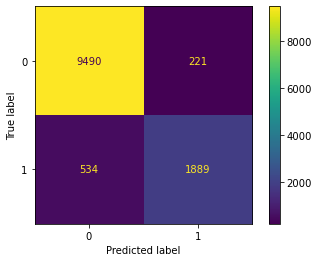

In [17]:
# Assess performance
from sklearn.metrics import roc_auc_score, f1_score

y_pred = search.predict(X_test)
y_pred_proba = search.predict_proba(X_test)
utilities.metrics_display(y_test, y_pred, y_pred_proba[:, 1])
# print(f"ROC AUC score: {roc_auc_score(y_test, y_pred_proba[:, 1])}")
# print(f"f1 score: {f1_score(y_test, y_pred)}")

In [25]:
top_n, best_score = extract_logs(search.cv_results_)
last_run_best_score.append(best_score)
if len(all_time_best_score)==0:
    all_time_best_score.append(best_score)
else:
    if all_time_best_score[0]<best_score:
        all_time_best_score[0] = best_score
prompt = suggest_refine_search_space(top_n, last_run_best_score[-1], all_time_best_score[-1])

In [30]:
# Refine search space
response = conversation.predict(input=prompt)
print(response)

Looking at the best configurations, we see some patterns:

- n_estimators: The values are on the higher end of the spectrum. This suggests that we could narrow the range to higher values.
- max_depth: The values are mostly around the middle of the range. We can leave this as is.
- min_child_weight: All the top configurations have this value as 1 or 2, suggesting we can narrow the search space.
- gamma: The values vary across the configurations. We can leave this as is.
- scale_pos_weight: The values are generally around the middle of the range. We can leave this as is.
- learning_rate: The values are on the lower end of the spectrum. This suggests that we could narrow the range to lower values.
- subsample, colsample_bylevel, colsample_bytree: The values are on the higher end of the spectrum. This suggests that we could narrow the range to higher values.
- reg_alpha, reg_lambda: The values vary across the configurations. This suggests that we could expand the range to explore more poss

In [31]:
%%time

search_space = {
    "n_estimators": scipy.stats.randint(500, 1000),
    "max_depth": scipy.stats.randint(3, 10),
    "min_child_weight": scipy.stats.randint(1, 3),
    "gamma": scipy.stats.uniform(0, 5),
    "scale_pos_weight": scipy.stats.uniform(1, 10),
    "learning_rate": scipy.stats.loguniform(0.01, 0.1),
    "subsample": scipy.stats.uniform(0.7, 0.3),
    "colsample_bylevel": scipy.stats.uniform(0.7, 0.3),
    "colsample_bytree": scipy.stats.uniform(0.7, 0.3),
    "reg_alpha": scipy.stats.loguniform(1e-6, 1000),
    "reg_lambda": scipy.stats.loguniform(1e-6, 1000),
}

clf = xgb.XGBClassifier(seed=42, objective='binary:logistic', 
                        eval_metric='logloss', n_jobs=-1, use_label_encoder=False)
# search = RandomizedSearchCV(clf, search_space, scoring='roc_auc', 
#                             n_iter=5, cv=5, verbose=1).fit(X_train, y_train)
search = HalvingRandomSearchCV(clf, search_space, scoring='f1', n_candidates=500,
                              cv=5, min_resources='exhaust', factor=3, verbose=1).fit(X_train, y_train)

n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 325
max_resources_: 78999
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 500
n_resources: 325
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
----------
iter: 1
n_candidates: 167
n_resources: 975
Fitting 5 folds for each of 167 candidates, totalling 835 fits
----------
iter: 2
n_candidates: 56
n_resources: 2925
Fitting 5 folds for each of 56 candidates, totalling 280 fits
----------
iter: 3
n_candidates: 19
n_resources: 8775
Fitting 5 folds for each of 19 candidates, totalling 95 fits
----------
iter: 4
n_candidates: 7
n_resources: 26325
Fitting 5 folds for each of 7 candidates, totalling 35 fits
CPU times: total: 5h 10min 33s
Wall time: 29min 16s


ROC_AUC score: 0.978
f1 score: 0.836
Accuracy: 93.80%
Precision: 88.81%
Detection rate: 78.91%
False alarm rate: 2.4817217588301927%
MCC: 0.80


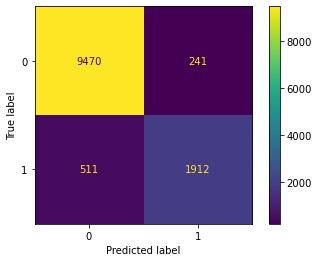

In [32]:
y_pred = search.predict(X_test)
y_pred_proba = search.predict_proba(X_test)
utilities.metrics_display(y_test, y_pred, y_pred_proba[:, 1])

In [33]:
top_n, best_score = extract_logs(search.cv_results_)
last_run_best_score.append(best_score)
if len(all_time_best_score)==0:
    all_time_best_score.append(best_score)
else:
    if all_time_best_score[0]<best_score:
        all_time_best_score[0] = best_score
prompt = suggest_refine_search_space(top_n, last_run_best_score[-1], all_time_best_score[-1])

In [35]:
print(prompt)


    Given your previously suggested search space, the obtained top configurations with their 
    test scores:
    Configuration 1 (0.9966 test score): colsample_bylevel: 0.7701307610565704, colsample_bytree: 0.7806492657742847, gamma: 1.7789426639142998, learning_rate: 0.09552112316589582, max_depth: 5, min_child_weight: 1, n_estimators: 702, reg_alpha: 0.1738761362842262, reg_lambda: 0.7975995338951125, scale_pos_weight: 4.7170071967577325, subsample: 0.9150451693550731
Configuration 2 (0.9965 test score): colsample_bylevel: 0.8017583276387795, colsample_bytree: 0.9127881694780163, gamma: 2.1403265472987556, learning_rate: 0.05394096581545913, max_depth: 5, min_child_weight: 1, n_estimators: 698, reg_alpha: 0.35713133161909666, reg_lambda: 0.00014671490036283997, scale_pos_weight: 5.77070313218654, subsample: 0.8600426987781119
Configuration 3 (0.9965 test score): colsample_bylevel: 0.7338692953597519, colsample_bytree: 0.7910565561097123, gamma: 2.841990474061382, learning_rate: 0.

In [39]:
# Refine search space
response = conversation.predict(input=prompt)
print(response)

Looking at the top configurations, we observe the following:

- n_estimators: The values are mostly around the middle of the range, suggesting we could narrow the range slightly.
- max_depth: The values are mostly around the middle of the range, suggesting we could narrow the range slightly.
- min_child_weight: All the top configurations have this value as 1 or 2, suggesting we can keep the current range.
- gamma: The values are varied, suggesting we can keep the current range.
- scale_pos_weight: The values are mostly around the middle of the range, suggesting we could narrow the range slightly.
- learning_rate: The values are varied, suggesting we can keep the current range.
- subsample, colsample_bylevel, colsample_bytree: The values are on the higher end of the spectrum, suggesting that we could narrow the range to higher values.
- reg_alpha, reg_lambda: The values are varied, but mostly small. This suggests that we could narrow the range to smaller values.

The refinements are bas

In [40]:
%%time

search_space = {
    "n_estimators": scipy.stats.randint(500, 1000),
    "max_depth": scipy.stats.randint(3, 10),
    "min_child_weight": scipy.stats.randint(1, 3),
    "gamma": scipy.stats.uniform(0, 5),
    "scale_pos_weight": scipy.stats.uniform(1, 10),
    "learning_rate": scipy.stats.loguniform(0.01, 0.1),
    "subsample": scipy.stats.uniform(0.7, 0.3),
    "colsample_bylevel": scipy.stats.uniform(0.7, 0.3),
    "colsample_bytree": scipy.stats.uniform(0.7, 0.3),
    "reg_alpha": scipy.stats.loguniform(1e-6, 1000),
    "reg_lambda": scipy.stats.loguniform(1e-6, 1000),
}

clf = xgb.XGBClassifier(seed=42, objective='binary:logistic', 
                        eval_metric='logloss', n_jobs=-1, use_label_encoder=False)
# search = RandomizedSearchCV(clf, search_space, scoring='roc_auc', 
#                             n_iter=5, cv=5, verbose=1).fit(X_train, y_train)
search = HalvingRandomSearchCV(clf, search_space, scoring='f1', n_candidates=100,
                              cv=5, min_resources='exhaust', factor=3, verbose=1).fit(X_train, y_train)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 975
max_resources_: 78999
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 100
n_resources: 975
Fitting 5 folds for each of 100 candidates, totalling 500 fits
----------
iter: 1
n_candidates: 34
n_resources: 2925
Fitting 5 folds for each of 34 candidates, totalling 170 fits
----------
iter: 2
n_candidates: 12
n_resources: 8775
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 3
n_candidates: 4
n_resources: 26325
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 4
n_candidates: 2
n_resources: 78975
Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: total: 2h 11min 38s
Wall time: 11min 57s


ROC_AUC score: 0.983
f1 score: 0.848
Accuracy: 94.22%
Precision: 89.50%
Detection rate: 80.52%
False alarm rate: 2.358150550921635%
MCC: 0.81


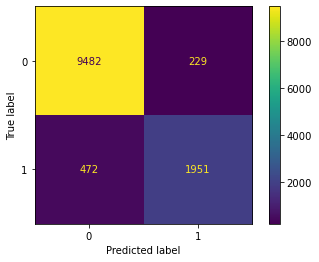

In [41]:
y_pred = search.predict(X_test)
y_pred_proba = search.predict_proba(X_test)
utilities.metrics_display(y_test, y_pred, y_pred_proba[:, 1])